 ## 1. Introduction

In this notebook, we implement a convolutional neural network (CNN) using Sequential model and transfer learning (MobileNetV2) to verifying vehicle damage claims and classify images as 'scratch' 'dent' 'tire flat' 'glass shatter' 'lamp broken' or 'crack'

The process includes data preprocessing, model training, evaluation and visualizations





### Libraries imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)


2.16.1


#### Loading Dataset

In [2]:
# Load training dataset
train_csv_path = "../archive (1)/train/train/train.csv"
train_image_dir = "../archive (1)/train/train/images"
train_data = pd.read_csv(train_csv_path)

# Load test dataset
test_csv_path = "../archive (1)/test/test/test.csv"
test_image_dir = "../archive (1)/test/test/images"
test_data_final = pd.read_csv(test_csv_path)

## 2. Exploratory Data Analysis (EDA)

In [3]:
# Check CSV structure and missing values
print("Training data decription:")
print(train_data.info())


print("Training CSV Head:")
print(train_data.head())

Training data decription:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  7200 non-null   int64 
 1   filename  7200 non-null   object
 2   label     7200 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 168.9+ KB
None
Training CSV Head:
   image_id filename  label
0         1    1.jpg      2
1         2    2.jpg      4
2         3    3.jpg      2
3         4    4.jpg      3
4         5    5.jpg      5


In [4]:
# Define label mapping
label_mapping = {
    1: 'crack',
    2: 'scratch',
    3: 'tire flat',
    4: 'dent',
    5: 'glass shatter',
    6: 'lamp broken'
}
train_data['label'] = train_data['label'].map(label_mapping)
print(train_data.head())
print(test_data_final.head())

   image_id filename          label
0         1    1.jpg        scratch
1         2    2.jpg           dent
2         3    3.jpg        scratch
3         4    4.jpg      tire flat
4         5    5.jpg  glass shatter
   image_id  filename
0      7201  7201.jpg
1      7202  7202.jpg
2      7203  7203.jpg
3      7204  7204.jpg
4      7205  7205.jpg


#### Display first five training images

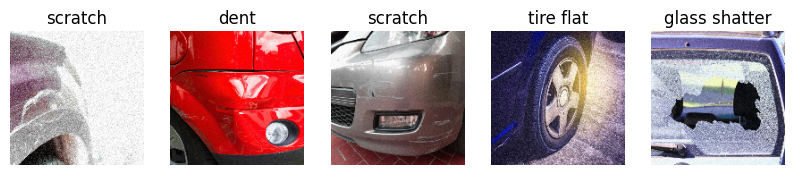

In [5]:
plt.figure(figsize=(10, 5))
for i, row in train_data.head(5).iterrows():
    img_path = os.path.join(train_image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(row['label'] )
    plt.axis('off')
plt.show()

In [6]:
# Print dataset size and target classes
print(f"Total training images: {len(train_data)}")
print(f"Total test images: {len(test_data_final)}")
print("Target classes:", train_data['label'].unique())

Total training images: 7200
Total test images: 4800
Target classes: ['scratch' 'dent' 'tire flat' 'glass shatter' 'lamp broken' 'crack']


## 3. Data Preprocessing

Includes:
- Train/Validation/Test split (Stratified)
- Resizing to 100x100
- Normalization
- Training Hyper-parameters tuning / Choosing best parameters
- Data augmentation




In [7]:

# Step 1: Split off 20% for testing (i.e., 1440 if 7200 total) Stratified
train_val_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# Step 2: Further split train_val_data into training and validation (e.g., 80%/20% split)
train_df, val_df = train_test_split(train_val_data, test_size=0.2, random_state=42, stratify=train_val_data['label'])

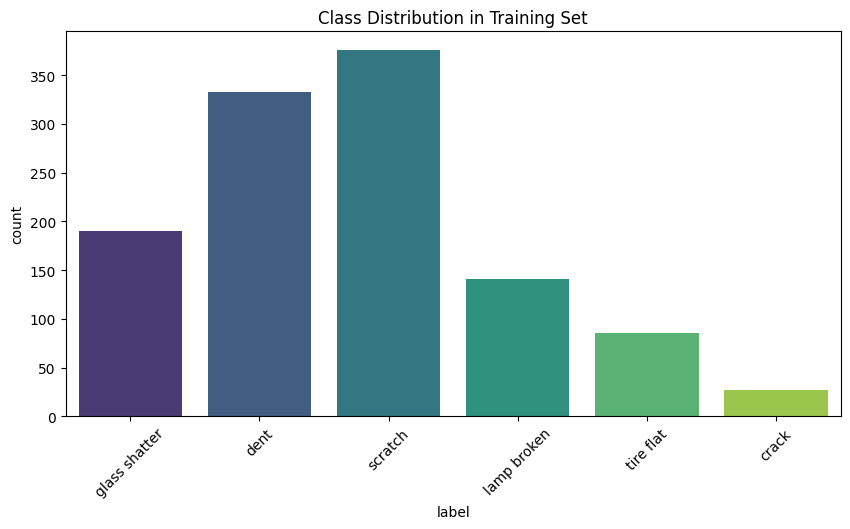

In [8]:
# Distribution of training dataset
plt.figure(figsize=(10, 5))
sns.countplot(data=val_df, x="label", palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

#### Deciding the best Hyperparameter tuning to train the model with

In [9]:
# Enable mixed precision (if using GPU)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define function for hyperparameter tuning
def hyperparameter_tuning(train_df, val_df, train_image_dir):
    results = []

    # Image augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True
    )

    # Only rescale for validation (no augmentation)
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Hyperparameter grid
    learning_rates = [1e-3, 1e-4]
    batch_sizes = [10, 15]
    epochs = [5, 10]
    dropout_rates = [0.3, 0.5]

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    csv_logger = CSVLogger("training_log.csv", append=True)

    # Loop through hyperparameter combinations
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for epoch in epochs:
                for dropout_rate in dropout_rates:
                    print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epoch}, dropout_rate={dropout_rate}")

                    # Build the model
                    model = Sequential([
                        Input(shape=(100, 100, 3)),
                        Conv2D(16, (3, 3), activation='relu'),
                        MaxPooling2D(2, 2),
                        Conv2D(32, (3, 3), activation='relu'),
                        MaxPooling2D(2, 2),
                        Flatten(),
                        Dense(64, activation='relu'),
                        Dropout(dropout_rate),
                        Dense(6, activation='softmax')
                    ])

                    # Compile the model
                    model.compile(optimizer=Adam(learning_rate=lr),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

                    # Training generator
                    train_generator = train_datagen.flow_from_dataframe(
                        dataframe=train_df,
                        directory=train_image_dir,
                        x_col='filename',
                        y_col='label',
                        target_size=(100, 100),
                        batch_size=batch_size,
                        class_mode='categorical',
                        workers=8,
                        use_multiprocessing=True,
                        shuffle=True
                    )

                    # Validation generator
                    val_generator = val_datagen.flow_from_dataframe(
                        dataframe=val_df,
                        directory=train_image_dir,
                        x_col='filename',
                        y_col='label',
                        target_size=(100, 100),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=False,
                        workers=8,
                        use_multiprocessing=True
                    )

                    # Train the model
                    history = model.fit(
                        train_generator,
                        validation_data=val_generator,
                        epochs=epoch,
                        callbacks=[early_stopping, reduce_lr, csv_logger],
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator)
                    )

                    # Evaluate the model
                    val_loss, val_acc = model.evaluate(val_generator)

                    # Store results
                    results.append({
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'epochs': epoch,
                        'dropout_rate': dropout_rate,
                        'val_loss': val_loss,
                        'val_accuracy': val_acc
                    })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Find best hyperparameter combination
    best_params = results_df.loc[results_df['val_accuracy'].idxmax()]
    print("\nBest Hyperparameters:")
    print(best_params)

    return results_df


# Sample a portion of the data
train_df_for_tuning = train_df.sample(frac=0.2)
val_df_for_tuning = val_df.sample(frac=0.2)

# Call the tuning function
results_df = hyperparameter_tuning(train_df_for_tuning, val_df_for_tuning, train_image_dir)

# Save results
results_df.to_csv("./hyperparameter_results.csv", index=False)

# Display results
print(results_df)

Training with lr=0.001, batch_size=10, epochs=5, dropout_rate=0.3
Found 922 validated image filenames belonging to 6 classes.
Found 230 validated image filenames belonging to 6 classes.
Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.2561 - loss: 2.5131 - val_accuracy: 0.2826 - val_loss: 1.6135 - learning_rate: 0.0010
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.3189 - loss: 1.5963 - val_accuracy: 0.3696 - val_loss: 1.5121 - learning_rate: 0.0010
Epoch 4/5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.3127 - loss: 1.4927 - val_accuracy: 0.

In [10]:
# Sort the DataFrame by 'val_accuracy' in descending order
best_combination = results_df.sort_values(by='val_accuracy', ascending=False).iloc[0]

# Display the best combination of hyperparameters
print("Best Hyperparameters:")
print(best_combination)

Best Hyperparameters:
learning_rate     0.001000
batch_size       10.000000
epochs           10.000000
dropout_rate      0.300000
val_loss          1.563556
val_accuracy      0.347826
Name: 2, dtype: float64


In [11]:
# Removing tailing zeros
learn_rate = float(f"{best_combination['learning_rate']:.5f}")
batch_size = int(best_combination['batch_size']) if best_combination['batch_size'].is_integer() else best_combination['batch_size']
epochs = int(best_combination['epochs']) if best_combination['epochs'].is_integer() else best_combination['epochs']


#### Data Augmentation with best hyper parameters


In [12]:
# Data augmentation artificially increases the size of the dataset and helps to prevent overfitting.
# csv_logger = CSVLogger("training_log.csv", append=True)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
csv_logger = CSVLogger("training_log.csv", append=True)

# Rescaling/ Normalizing the dataset with Augment data (rotation, flipping).
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)


# Common generator arguments
common_gen_args = dict(
    rescale=1./255,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    workers=8,
    use_multiprocessing=True,
    prefetch=True
)



train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='label',
    shuffle=True,
    **common_gen_args
)

# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='label',
    shuffle=False,
    **common_gen_args
)


Found 4608 validated image filenames belonging to 6 classes.
Found 1152 validated image filenames belonging to 6 classes.


## 4. Define CNN Model

In [13]:
# CNN model using TensorFlow/Keras:
model = Sequential([
              Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
              MaxPooling2D(2,2),
              Conv2D(32, (3,3), activation='relu'),
              MaxPooling2D(2,2),
              Flatten(),
              Dense(64, activation='relu'),
              Dropout(0.3),
              Dense(6, activation='softmax')
                ])

#### Compile Model

In [14]:
model.compile(optimizer=Adam(learning_rate=learn_rate), loss='categorical_crossentropy', metrics=['accuracy'])


#### Show Model Summary

In [15]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 16928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │       1,083,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,088,934 (4.15 MB)

 Trainable params: 1,088,934 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

In [16]:
history = model.fit(
                        train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        callbacks=[early_stopping, reduce_lr, csv_logger],
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator),
                    )


Epoch 1/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accuracy: 0.3060 - loss: 1.6970 - val_accuracy: 0.3845 - val_loss: 1.4136 - learning_rate: 0.0010
Epoch 2/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - accuracy: 0.3768 - loss: 1.4275 - val_accuracy: 0.4436 - val_loss: 1.3061 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - accuracy: 0.4469 - loss: 1.2766 - val_accuracy: 0.4852 - val_loss: 1.1735 - learning_rate: 5.0000e-04


### Checking for overfitting
Plot training loss against validation loss

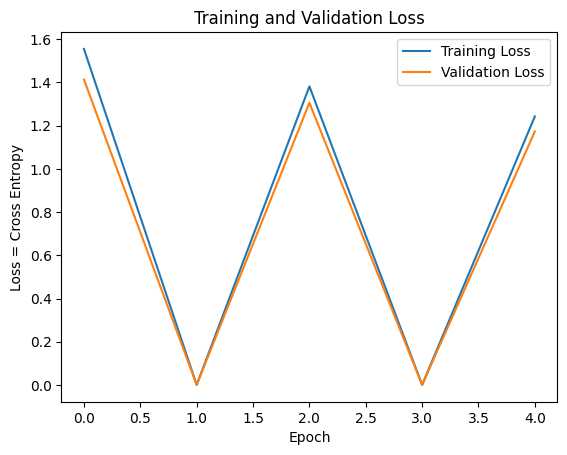

In [17]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss = Cross Entropy')
plt.legend()
plt.show()

#### Plot training and validation accuracy

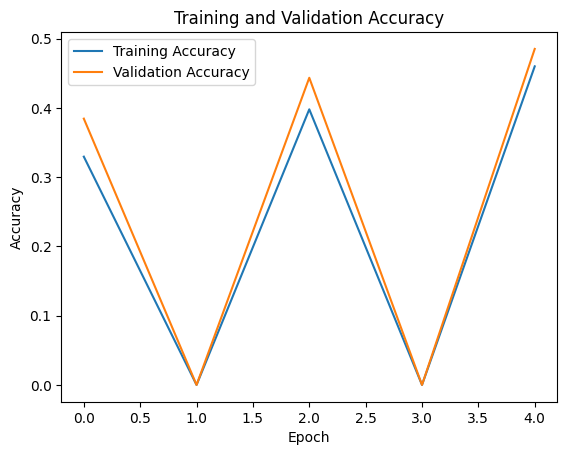

In [18]:
#  Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 6. Model Evaluation

- Evaluate model using accuracy, precision, recall, and F1-score.

- Shows:

- Confusion matrix

- Classification report

In [19]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4046 - loss: 1.3964
Validation Loss: 1.4136
Validation Accuracy: 0.3845


#### Generate Predictions

In [20]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_data,
    directory=train_image_dir,  # test_data comes from the original training images
    x_col='filename',
    y_col='label',
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=8,
    prefetch=True,
    use_multiprocessing=True
)





Found 1440 validated image filenames belonging to 6 classes.


In [21]:

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = test_generator.classes
class_labels = list(label_mapping.values())

144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step


### Classification Report and Confusion Matrix

In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

Classification Report:
               precision    recall  f1-score   support

        crack       0.00      0.00      0.00        34
      scratch       0.47      0.27      0.35       416
    tire flat       0.35      0.38      0.36       237
         dent       0.00      0.00      0.00       176
glass shatter       0.36      0.70      0.47       470
  lamp broken       0.72      0.12      0.21       107

     accuracy                           0.38      1440
    macro avg       0.32      0.25      0.23      1440
 weighted avg       0.36      0.38      0.33      1440



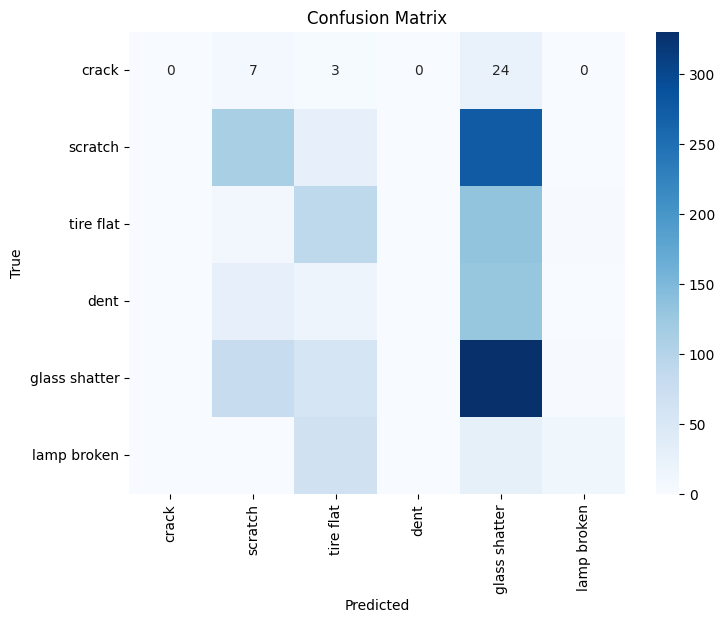

In [23]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, class_labels)

In [24]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=[f'True: {label}' for label in class_labels],
                         columns=[f'Pred: {label}' for label in class_labels])

# Print it as a table
print("Confusion Matrix (Table Format):")
print(cm_df)

Confusion Matrix (Table Format):
                     Pred: crack  Pred: scratch  Pred: tire flat  Pred: dent  \
True: crack                    0              7                3           0   
True: scratch                  0            113               28           0   
True: tire flat                0             11               91           0   
True: dent                     0             28               18           0   
True: glass shatter            0             80               58           0   
True: lamp broken              0              0               65           0   

                     Pred: glass shatter  Pred: lamp broken  
True: crack                           24                  0  
True: scratch                        275                  0  
True: tire flat                      133                  2  
True: dent                           129                  1  
True: glass shatter                  330                  2  
True: lamp broken                 

#### Save the Model

In [29]:
# model.save("damage_claim_model.h5")
# print("Model saved successfully!")

model.save("damage_claim_model.keras")
print("Model saved successfully!")

Model saved successfully!


#### Final Test Prediction

In [30]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_data_final,
    directory=test_image_dir,  # test_data comes from the original testing images
    x_col='filename',
    y_col=None,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    workers=8,
    prefetch=True,
    use_multiprocessing=True
)


y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices



# Convert to DataFrame
predictions_df = pd.DataFrame({
    'filename': test_generator.filenames,
    'predicted_class': y_pred_classes
})

Found 4800 validated image filenames.
480/480 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step


#### Save Predictions to CSV

In [31]:
output_csv_path = "predictions.csv"
predictions_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")


Predictions saved to predictions.csv


## 7. Transfer Learning with MobileNetV2

#### Prepare the dataset

In [32]:
# Pretrained weights (like those trained on ImageNet) are optimized for 224x224.
img_size = 224
batch_size = 32

# Training Generator
train_generator = datagen.flow_from_dataframe(
                        dataframe=train_df,
                        directory=train_image_dir,
                        x_col='filename',
                        y_col='label',
                        target_size=(img_size, img_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        workers=8,
                        use_multiprocessing=True,
                        prefetch=True,
                        max_queue_size=20
                    )

# Validation Generator
val_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
                        dataframe=val_df,
                        directory=train_image_dir,
                        x_col='filename',
                        y_col='label',
                        target_size=(img_size, img_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=False,
                        workers=8,
                        prefetch=True,
                        use_multiprocessing=True
                    )


Found 4608 validated image filenames belonging to 6 classes.
Found 1152 validated image filenames belonging to 6 classes.


#### Load a MobileNetV2 pre-trained model (Transfer Learning)

In [33]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # freeze base model for feature extraction



x=base_model.output
x=GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3

num_classes = len(train_generator.class_indices)

output = Dense(num_classes, activation='softmax')(x)

model2=Model(inputs=base_model.input,outputs=output)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Lets check the model architecture

In [34]:
for i,layer in enumerate(model2.layers):
  print(i,layer.name)

0 input_layer_17
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_re

In [35]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the model

In [36]:
history = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 144s 960ms/step - accuracy: 0.4852 - loss: 2.0495 - val_accuracy: 0.6884 - val_loss: 0.8391
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 787ms/step - accuracy: 0.7061 - loss: 0.7574 - val_accuracy: 0.7196 - val_loss: 0.6885
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 797ms/step - accuracy: 0.7397 - loss: 0.6703 - val_accuracy: 0.7578 - val_loss: 0.5975
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 803ms/step - accuracy: 0.7528 - loss: 0.6190 - val_accuracy: 0.7665 - val_loss: 0.6367
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 786ms/step - accuracy: 0.7889 - loss: 0.5502 - val_accuracy: 0.7917 - val_loss: 0.5717


### Checking for overfitting
#### Plot training loss against validation loss

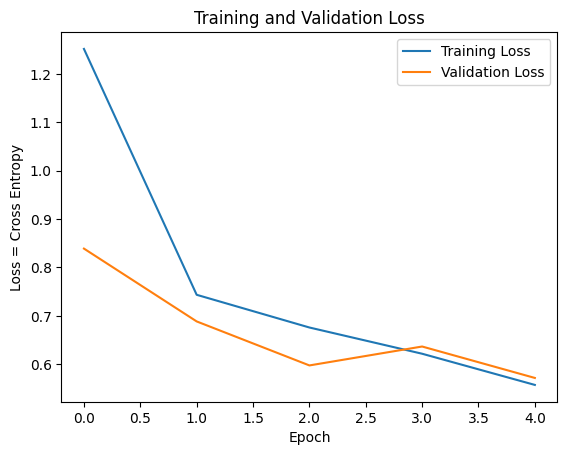

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss = Cross Entropy')
plt.legend()
plt.show()

#  Plot training and validation accuracy

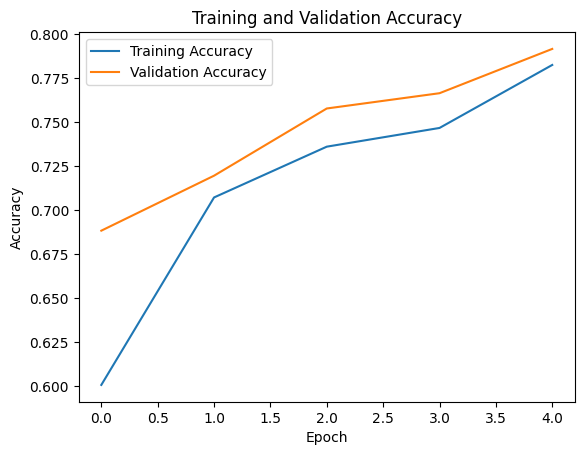

In [38]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Evaluate the model

In [39]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_data,
    directory=train_image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=8,
    prefetch=True,
    use_multiprocessing=True
)


y_pred_pretrained_model = model2.predict(test_generator)
y_pred_classes_pretrained = np.argmax(y_pred_pretrained_model, axis=1)  # Convert probabilities to class indices
y_true_pretrained_model = test_generator.classes


Found 1440 validated image filenames belonging to 6 classes.
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 649ms/step


Classification Report on MobileNet:
               precision    recall  f1-score   support

        crack       1.00      0.06      0.11        34
      scratch       0.76      0.67      0.71       416
    tire flat       0.94      0.91      0.92       237
         dent       0.81      0.68      0.74       176
glass shatter       0.70      0.86      0.77       470
  lamp broken       0.92      0.96      0.94       107

     accuracy                           0.78      1440
    macro avg       0.85      0.69      0.70      1440
 weighted avg       0.79      0.78      0.77      1440



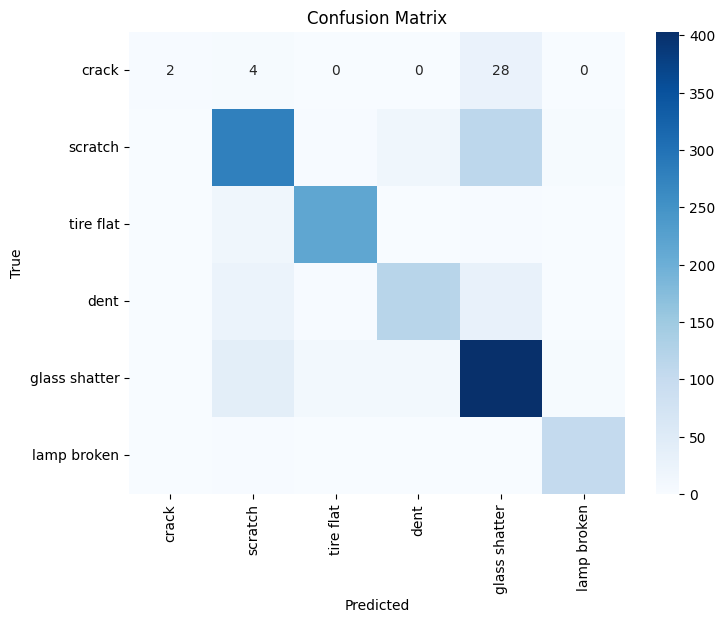

In [40]:
print("Classification Report on MobileNet:")
print(classification_report(y_true_pretrained_model, y_pred_classes_pretrained, target_names=class_labels))

cm_mobileNet = confusion_matrix(y_true_pretrained_model, y_pred_classes_pretrained)
plot_confusion_matrix(cm_mobileNet, class_labels)

In [41]:
# Create a DataFrame for the confusion matrix
cm_df_mobileNet = pd.DataFrame(cm_mobileNet, index=[f'True: {label}' for label in class_labels],
                         columns=[f'Pred: {label}' for label in class_labels])


print("Confusion Matrix (Table Format):")
print(cm_df_mobileNet)

Confusion Matrix (Table Format):
                     Pred: crack  Pred: scratch  Pred: tire flat  Pred: dent  \
True: crack                    2              4                0           0   
True: scratch                  0            279                3          17   
True: tire flat                0             17              216           0   
True: dent                     0             24                2         119   
True: glass shatter            0             42               10          11   
True: lamp broken              0              3                0           0   

                     Pred: glass shatter  Pred: lamp broken  
True: crack                           28                  0  
True: scratch                        113                  4  
True: tire flat                        3                  1  
True: dent                            31                  0  
True: glass shatter                  403                  4  
True: lamp broken                 

#### Save model

In [43]:

model2.save("vehincle_damage_claim_model2.keras")
print("Model2 saved successfully!")

Model2 saved successfully!


#### Model2 Prediction on final test data

In [44]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_data_final,
    directory=test_image_dir,
    x_col='filename',
    y_col=None,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    workers=8,
    prefetch=True,
    use_multiprocessing=True
)


y_pred = model2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)



# Convert to DataFrame
predictions2_df = pd.DataFrame({
    'filename': test_generator.filenames,
    'predicted_class': y_pred_classes
})

Found 4800 validated image filenames.
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 848ms/step


####Saving Predictions to file

In [45]:
output_csv_path = "predictions2.csv"
predictions2_df.to_csv(output_csv_path, index=False)
print(f"Predictions2 saved to {output_csv_path}")


Predictions2 saved to predictions2.csv
